# Importing libraries and Data

In [3]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os

In [5]:
#Create a path and import the dataframe
path = r'/Users/buketoztekin/Documents/Quantium/'
file_path = os.path.join(path, '2_Data', 'data_normal.csv')
df = pd.read_csv(file_path)

In [7]:
df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,BULK_PURCHASE,PRICE_PER_UNIT
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural Chip Company,NO,3.0
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,Red Rock Deli,NO,2.7
2,1003,YOUNG FAMILIES,Budget,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,Grain Waves,NO,3.6
3,1003,YOUNG FAMILIES,Budget,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,Natural Chip Company,NO,3.0
4,1004,OLDER SINGLES/COUPLES,Mainstream,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,Woolworths,NO,1.9


In [9]:
df.shape

(245301, 14)

In [13]:
# Ensure the column is in datetime format
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")  # Convert to datetime

# Now convert to YYYYMM format
df["YEARMONTH"] = df["DATE"].dt.strftime("%Y%m").astype(int)

# Check the result
print(df[["DATE", "YEARMONTH"]].head())

        DATE  YEARMONTH
0 2018-10-17     201810
1 2018-09-16     201809
2 2019-03-07     201903
3 2019-03-08     201903
4 2018-11-02     201811


# Selecting Control Stores

In [34]:
# Aggregate monthly metrics for each store
store_metrics = df.groupby(["STORE_NBR", "YEARMONTH"]).agg(
    totSales=("TOT_SALES", "sum"),        
    nCustomers=("LYLTY_CARD_NBR", "nunique"),  
    nTxn=("TXN_ID", "count")             
).reset_index()

# Compute transactions per customer
store_metrics["nTxnPerCust"] = store_metrics["nTxn"] / store_metrics["nCustomers"]

# View the first few rows
print(store_metrics.head(10))

   STORE_NBR  YEARMONTH  totSales  nCustomers  nTxn  nTxnPerCust
0          1     201807     188.9          47    49     1.042553
1          1     201808     168.4          41    41     1.000000
2          1     201809     268.1          57    59     1.035088
3          1     201810     175.4          39    40     1.025641
4          1     201811     184.8          44    45     1.022727
5          1     201812     160.6          37    40     1.081081
6          1     201901     144.5          33    33     1.000000
7          1     201902     192.1          48    50     1.041667
8          1     201903     185.2          43    47     1.093023
9          1     201904     177.4          39    40     1.025641


In [36]:
# Keep only pre-trial data (before February 2019)
pre_trial_stores = store_metrics[store_metrics["YEARMONTH"] < 201902]

# Check the first few rows
print(pre_trial_stores.head())

   STORE_NBR  YEARMONTH  totSales  nCustomers  nTxn  nTxnPerCust
0          1     201807     188.9          47    49     1.042553
1          1     201808     168.4          41    41     1.000000
2          1     201809     268.1          57    59     1.035088
3          1     201810     175.4          39    40     1.025641
4          1     201811     184.8          44    45     1.022727


In [38]:
from scipy.stats import pearsonr
import numpy as np

def compute_similarity_scores(df, trial_store, metric):
    """
    Computes correlation and magnitude distance between a trial store and all potential control stores.
    
    Parameters:
    df (DataFrame): The dataset containing sales and customer data.
    trial_store (int): The trial store number.
    metric (str): The column name to compare (e.g., "totSales" or "nCustomers").
    
    Returns:
    DataFrame: A table ranking control stores by similarity.
    """
    corr_scores = {}  
    mag_scores = {}  

    # Get trial store data
    trial_data = df[df["STORE_NBR"] == trial_store][["YEARMONTH", metric]]

    # Get all store numbers except the trial store
    store_numbers = df["STORE_NBR"].unique()
    
    # Get min and max values for standardization
    min_value, max_value = df[metric].min(), df[metric].max()

    for store in store_numbers:
        if store == trial_store:
            continue  

        control_data = df[df["STORE_NBR"] == store][["YEARMONTH", metric]]

        # Merge to find common months
        merged = trial_data.merge(control_data, on="YEARMONTH", suffixes=("_trial", "_control"))

        # Ensure at least 2 data points exist
        if len(merged) < 2:
            continue  

        # Compute Pearson correlation
        if merged[f"{metric}_trial"].nunique() > 1 and merged[f"{metric}_control"].nunique() > 1:
            corr, _ = pearsonr(merged[f"{metric}_trial"], merged[f"{metric}_control"])
            corr_scores[store] = corr
        
        # Compute Magnitude Distance
        abs_diff = np.abs(merged[f"{metric}_trial"] - merged[f"{metric}_control"])
        standardized = 1 - (abs_diff - min_value) / (max_value - min_value)
        mag_scores[store] = np.mean(standardized)

    # Create DataFrame with similarity scores
    score_df = pd.DataFrame({
        "Store": list(corr_scores.keys()),
        "corrScore": list(corr_scores.values()),
        "magScore": list(mag_scores.values()),
    })
    
    # Compute final similarity score (equal weight to both measures)
    score_df["finalScore"] = (score_df["corrScore"] + score_df["magScore"]) / 2

    return score_df.sort_values("finalScore", ascending=False)


In [40]:
similarity_scores_77 = compute_similarity_scores(pre_trial_stores, trial_store=77, metric="totSales")
print(similarity_scores_77.head())  # Show top-ranked stores

     Store  corrScore  magScore  finalScore
225    233   0.951196  0.989073    0.970135
30      31   1.000000  0.864796    0.932398
10      11   1.000000  0.860522    0.930261
49      50   0.879619  0.980644    0.930131
162    167   0.691851  0.965126    0.828488


In [42]:
similarity_scores_86 = compute_similarity_scores(pre_trial_stores, trial_store=86, metric="totSales")
print(similarity_scores_86.head())  # Show top-ranked stores


     Store  corrScore  magScore  finalScore
150    155   0.841769  0.977738    0.909753
133    138   0.768387  0.971576    0.869982
214    222   0.732338  0.967472    0.849905
109    114   0.732400  0.966669    0.849534
260    269   0.732381  0.955627    0.844004


In [44]:
similarity_scores_88 = compute_similarity_scores(pre_trial_stores, trial_store=88, metric="totSales")
print(similarity_scores_88.head())  # Show top-ranked stores


     Store  corrScore  magScore  finalScore
87      91   0.911986  0.723293    0.817640
77      79   0.771989  0.802926    0.787458
6        7   0.698846  0.826061    0.762453
217    225   0.721337  0.698437    0.709887
195    201   0.484138  0.901420    0.692779


# Preparing Data for Plotting for Only Trial and Control Stores

In [55]:
# Define trial & control store mappings
trial_control_pairs = {77: 224, 86: 150, 88: 87}

# Filter data to include only trial and control stores
plot_data = pre_trial_stores[pre_trial_stores["STORE_NBR"].isin(trial_control_pairs.keys()) |
                             pre_trial_stores["STORE_NBR"].isin(trial_control_pairs.values())].copy()

# Label stores as "Trial" or "Control"
plot_data["Store_Type"] = plot_data["STORE_NBR"].map(lambda x: "Trial" if x in trial_control_pairs.keys() else "Control")

# Convert YEARMONTH to a proper datetime format for plotting
plot_data["YearMonth"] = pd.to_datetime(plot_data["YEARMONTH"].astype(str), format="%Y%m")

# View prepared data
print(plot_data.head())

     STORE_NBR  YEARMONTH  totSales  nCustomers  nTxn  nTxnPerCust Store_Type  \
880         77     201807     268.4          47    51     1.085106      Trial   
881         77     201808     247.5          46    46     1.000000      Trial   
882         77     201809     214.2          39    41     1.051282      Trial   
883         77     201810     194.3          36    37     1.027778      Trial   
884         77     201811     224.9          39    42     1.076923      Trial   

     YearMonth  
880 2018-07-01  
881 2018-08-01  
882 2018-09-01  
883 2018-10-01  
884 2018-11-01  


# Plotting total sales trends

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


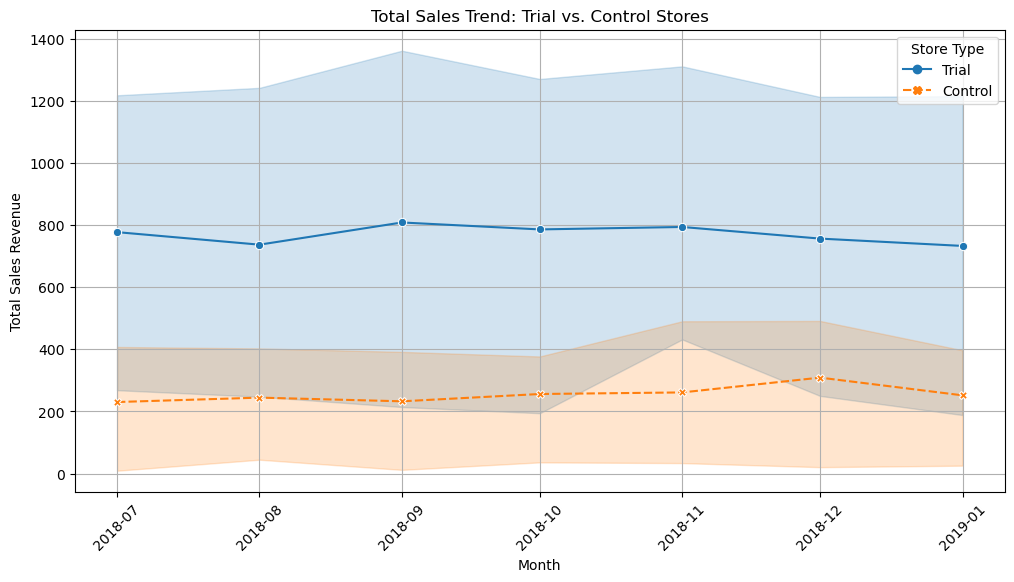

In [58]:
plt.figure(figsize=(12, 6))

# Plot sales trends for trial and control stores
sns.lineplot(data=plot_data, x="YearMonth", y="totSales", hue="Store_Type", style="Store_Type", markers=True)

plt.title("Total Sales Trend: Trial vs. Control Stores")
plt.xlabel("Month")
plt.ylabel("Total Sales Revenue")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plotting Customer Number Trends

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


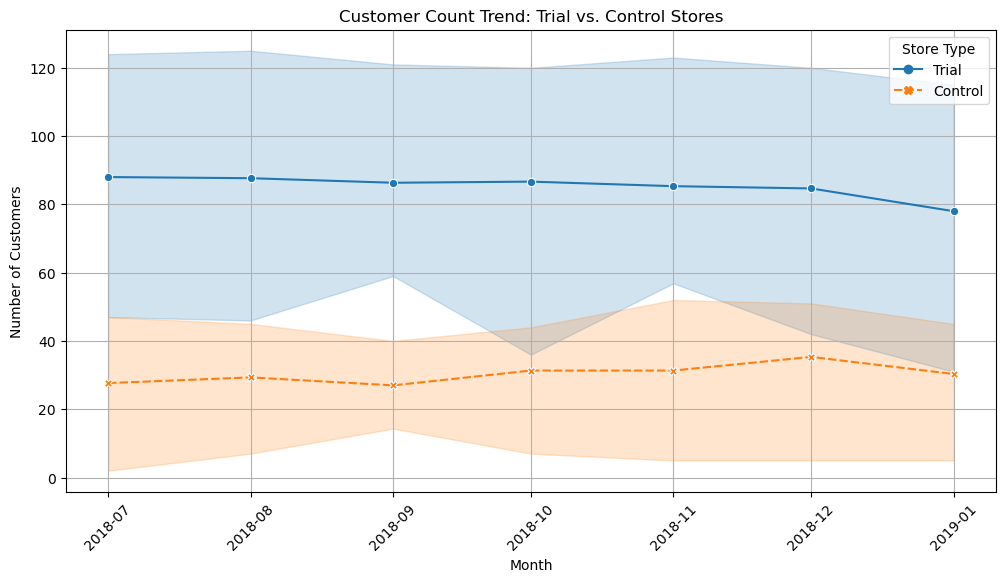

In [61]:
plt.figure(figsize=(12, 6))

# Plot customer trends for trial and control stores
sns.lineplot(data=plot_data, x="YearMonth", y="nCustomers", hue="Store_Type", style="Store_Type", markers=True)

plt.title("Customer Count Trend: Trial vs. Control Stores")
plt.xlabel("Month")
plt.ylabel("Number of Customers")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Plotting transaction per customer trends

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


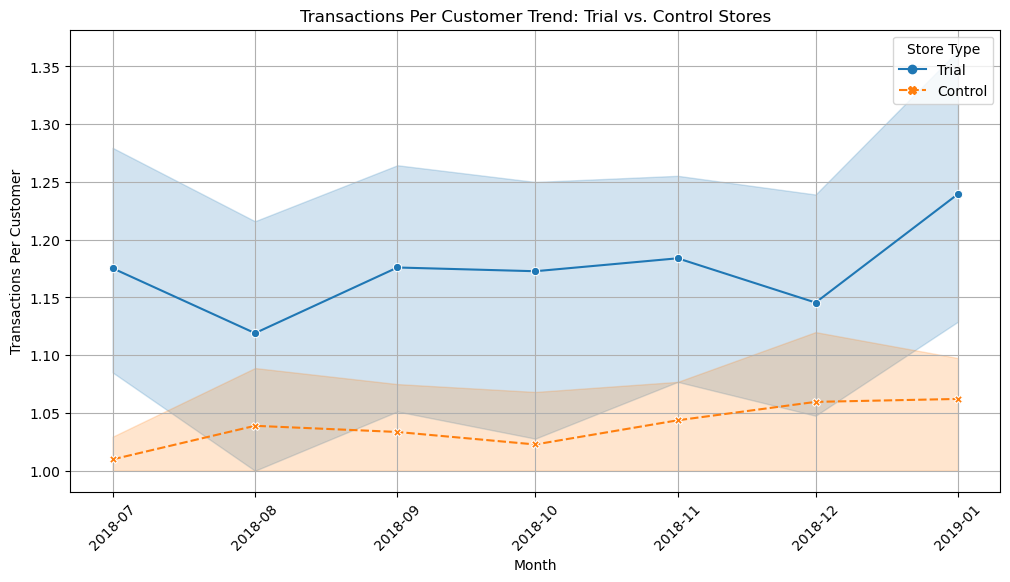

In [63]:
plt.figure(figsize=(12, 6))

# Plot transactions per customer for trial and control stores
sns.lineplot(data=plot_data, x="YearMonth", y="nTxnPerCust", hue="Store_Type", style="Store_Type", markers=True)

plt.title("Transactions Per Customer Trend: Trial vs. Control Stores")
plt.xlabel("Month")
plt.ylabel("Transactions Per Customer")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Checking for better matching trial and control stores with absolute values

In [68]:
# Compute average metrics for each store
store_comparison = pre_trial_stores.groupby("STORE_NBR").agg(
    avgSales=("totSales", "mean"),
    avgCustomers=("nCustomers", "mean"),
    avgTxnPerCust=("nTxnPerCust", "mean")
).reset_index()

# Get trial store values (ensure correct indexing)
trial_store_values = store_comparison[store_comparison["STORE_NBR"] == 77]

# Compute absolute differences from the trial store
store_comparison["salesDiff"] = abs(store_comparison["avgSales"] - trial_store_values["avgSales"].values[0])
store_comparison["custDiff"] = abs(store_comparison["avgCustomers"] - trial_store_values["avgCustomers"].values[0])
store_comparison["txnDiff"] = abs(store_comparison["avgTxnPerCust"] - trial_store_values["avgTxnPerCust"].values[0])

# Rank stores based on similarity (lower difference is better)
store_comparison["totalDiff"] = store_comparison["salesDiff"] + store_comparison["custDiff"] + store_comparison["txnDiff"]

# Sort by best match
best_alternative = store_comparison.sort_values("totalDiff").head(10)
print(best_alternative)


     STORE_NBR    avgSales  avgCustomers  avgTxnPerCust  salesDiff  custDiff  \
76          77  226.814286     40.000000       1.059677   0.000000  0.000000   
45          46  225.371429     38.571429       1.039172   1.442857  1.428571   
89          90  230.185714     38.285714       1.043004   3.371429  1.714286   
217        220  233.585714     43.857143       1.036887   6.771429  3.857143   
185        187  232.242857     34.428571       1.071010   5.428571  5.571429   
230        233  215.871429     38.857143       1.027821  10.942857  1.142857   
193        195  214.321429     40.285714       1.040976  12.492857  0.285714   
5            6  212.785714     39.714286       1.048569  14.028571  0.285714   
252        255  212.585714     39.428571       1.039945  14.228571  0.571429   
203        205  241.785714     38.142857       1.049829  14.971429  1.857143   

      txnDiff  totalDiff  
76   0.000000   0.000000  
45   0.020505   2.891934  
89   0.016673   5.102387  
217  0.0227

In [71]:
# Compute average metrics for each store
store_comparison = pre_trial_stores.groupby("STORE_NBR").agg(
    avgSales=("totSales", "mean"),
    avgCustomers=("nCustomers", "mean"),
    avgTxnPerCust=("nTxnPerCust", "mean")
).reset_index()

# Get trial store values (ensure correct indexing)
trial_store_values = store_comparison[store_comparison["STORE_NBR"] == 86]

# Compute absolute differences from the trial store
store_comparison["salesDiff"] = abs(store_comparison["avgSales"] - trial_store_values["avgSales"].values[0])
store_comparison["custDiff"] = abs(store_comparison["avgCustomers"] - trial_store_values["avgCustomers"].values[0])
store_comparison["txnDiff"] = abs(store_comparison["avgTxnPerCust"] - trial_store_values["avgTxnPerCust"].values[0])

# Rank stores based on similarity (lower difference is better)
store_comparison["totalDiff"] = store_comparison["salesDiff"] + store_comparison["custDiff"] + store_comparison["txnDiff"]

# Sort by best match
best_alternative = store_comparison.sort_values("totalDiff").head(10)
print(best_alternative)


     STORE_NBR    avgSales  avgCustomers  avgTxnPerCust  salesDiff  custDiff  \
85          86  822.750000     94.571429       1.247352   0.000000  0.000000   
136        138  822.842857     95.000000       1.245677   0.092857  0.428571   
95          97  821.678571     94.428571       1.253318   1.071429  0.142857   
107        109  823.300000     93.714286       1.258267   0.550000  0.857143   
162        164  820.985714     93.714286       1.262707   1.764286  0.857143   
29          30  819.528571     92.285714       1.242776   3.221429  2.285714   
178        180  818.171429     93.571429       1.259382   4.578571  1.000000   
224        227  827.857143     94.000000       1.256231   5.107143  0.571429   
61          62  828.228571     93.428571       1.269548   5.478571  1.142857   
9           10  831.192857     95.142857       1.235974   8.442857  0.571429   

      txnDiff  totalDiff  
85   0.000000   0.000000  
136  0.001675   0.523103  
95   0.005966   1.220252  
107  0.0109

In [73]:
# Compute average metrics for each store
store_comparison = pre_trial_stores.groupby("STORE_NBR").agg(
    avgSales=("totSales", "mean"),
    avgCustomers=("nCustomers", "mean"),
    avgTxnPerCust=("nTxnPerCust", "mean")
).reset_index()

# Get trial store values (ensure correct indexing)
trial_store_values = store_comparison[store_comparison["STORE_NBR"] == 88]

# Compute absolute differences from the trial store
store_comparison["salesDiff"] = abs(store_comparison["avgSales"] - trial_store_values["avgSales"].values[0])
store_comparison["custDiff"] = abs(store_comparison["avgCustomers"] - trial_store_values["avgCustomers"].values[0])
store_comparison["txnDiff"] = abs(store_comparison["avgTxnPerCust"] - trial_store_values["avgTxnPerCust"].values[0])

# Rank stores based on similarity (lower difference is better)
store_comparison["totalDiff"] = store_comparison["salesDiff"] + store_comparison["custDiff"] + store_comparison["txnDiff"]

# Sort by best match
best_alternative = store_comparison.sort_values("totalDiff").head(10)
print(best_alternative)


     STORE_NBR     avgSales  avgCustomers  avgTxnPerCust   salesDiff  \
87          88  1261.828571    121.142857       1.212479    0.000000   
234        237  1273.585714    121.714286       1.205631   11.757143   
163        165  1249.742857    118.142857       1.208539   12.085714   
57          58  1225.278571    118.857143       1.191956   36.550000   
3            4  1225.171429    115.857143       1.220303   36.657143   
201        203  1185.871429    113.714286       1.200172   75.957143   
39          40  1174.885714    116.571429       1.156138   86.942857   
197        199  1171.500000    113.571429       1.186255   90.328571   
223        226  1379.678571    130.714286       1.227861  117.850000   
25          26  1136.928571    111.428571       1.162631  124.900000   

     custDiff   txnDiff   totalDiff  
87   0.000000  0.000000    0.000000  
234  0.571429  0.006848   12.335419  
163  3.000000  0.003940   15.089654  
57   2.285714  0.020523   38.856238  
3    5.285714  0.

In [79]:
# Define new trial & control store mappings (updated based on absolute difference analysis)
new_trial_control_pairs = {77: 46, 86: 138, 88: 237}  # Replace with actual control stores

# Filter data to include only new trial and control stores
pre_trial_stores2 = store_metrics[store_metrics["STORE_NBR"].isin(new_trial_control_pairs.keys()) |
                                  store_metrics["STORE_NBR"].isin(new_trial_control_pairs.values())].copy()

# Label stores as "Trial" or "Control"
pre_trial_stores2["Store_Type"] = pre_trial_stores2["STORE_NBR"].map(lambda x: "Trial" if x in new_trial_control_pairs.keys() else "Control")

# Convert YEARMONTH to datetime format
pre_trial_stores2["YearMonth"] = pd.to_datetime(pre_trial_stores2["YEARMONTH"].astype(str), format="%Y%m")

# View prepared data
print(pre_trial_stores2.head())

     STORE_NBR  YEARMONTH  totSales  nCustomers  nTxn  nTxnPerCust Store_Type  \
519         46     201807     198.4          38    39     1.026316    Control   
520         46     201808     222.1          39    41     1.051282    Control   
521         46     201809     215.0          38    40     1.052632    Control   
522         46     201810     259.9          43    44     1.023256    Control   
523         46     201811     241.9          37    39     1.054054    Control   

     YearMonth  
519 2018-07-01  
520 2018-08-01  
521 2018-09-01  
522 2018-10-01  
523 2018-11-01  


# Plot Sales Trends (New Control Stores)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


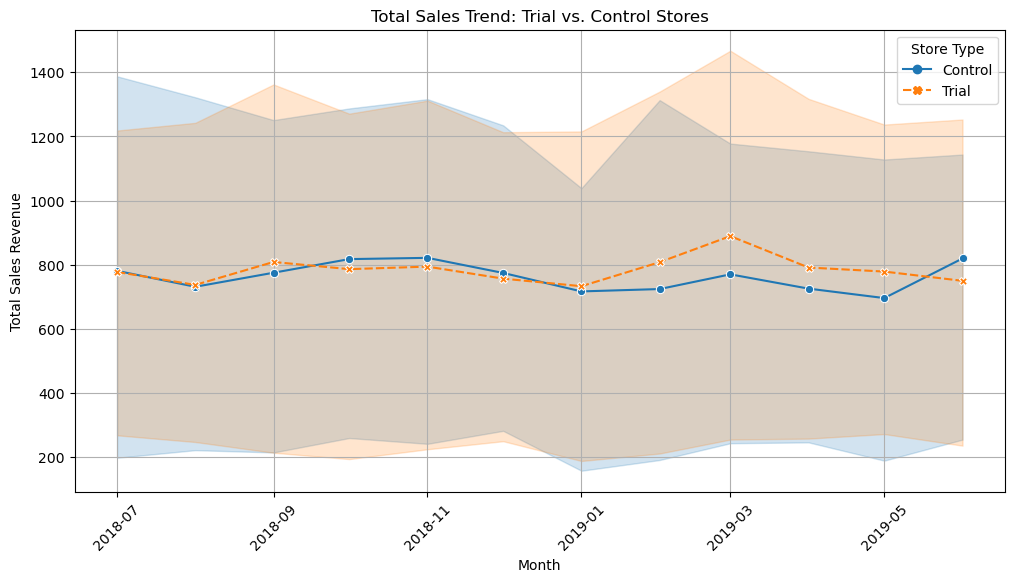

In [84]:
plt.figure(figsize=(12, 6))

# Plot sales trends for trial and control stores
sns.lineplot(data=pre_trial_stores2, x="YearMonth", y="totSales", hue="Store_Type", style="Store_Type", markers=True)

plt.title("Total Sales Trend: Trial vs. Control Stores")
plt.xlabel("Month")
plt.ylabel("Total Sales Revenue")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#  Plot Customer Count Trend (New Control Stores)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


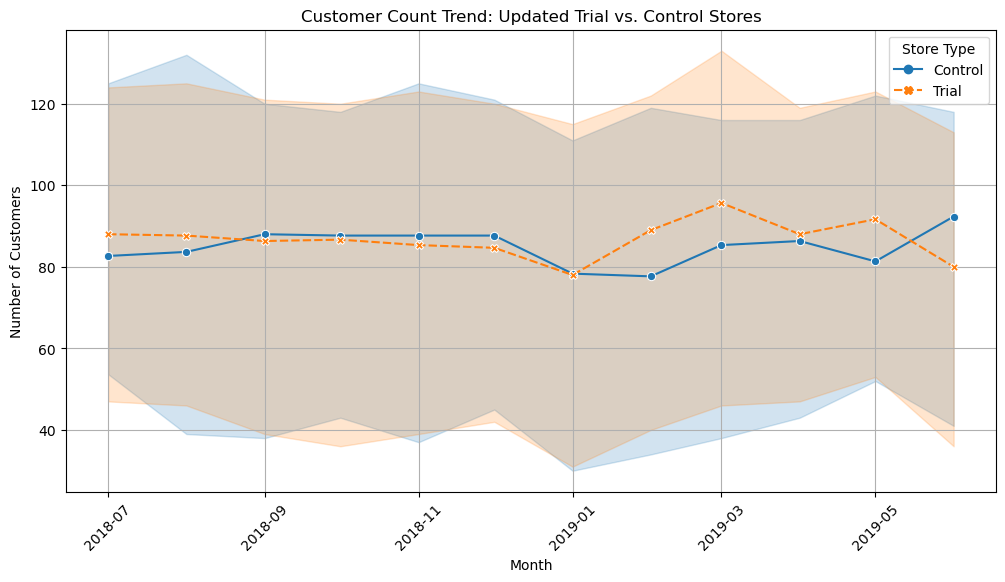

In [88]:
plt.figure(figsize=(12, 6))

# Plot customer trends for trial and control stores
sns.lineplot(data=pre_trial_stores2, x="YearMonth", y="nCustomers", hue="Store_Type", style="Store_Type", markers=True)

plt.title("Customer Count Trend: Updated Trial vs. Control Stores")
plt.xlabel("Month")
plt.ylabel("Number of Customers")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot Transactions Per Customer Trend (New Control Stores)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


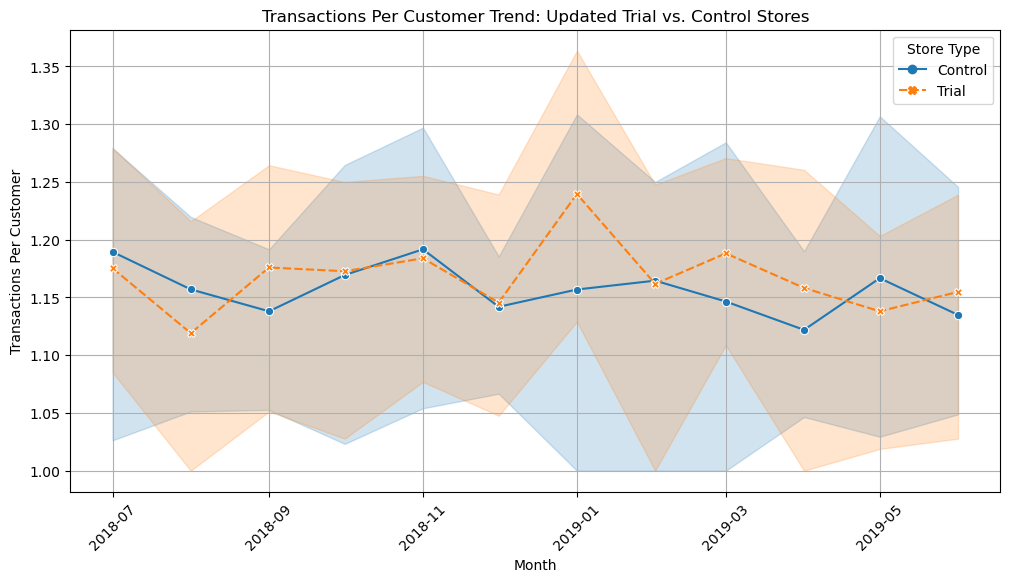

In [91]:
plt.figure(figsize=(12, 6))

# Plot transactions per customer for trial and control stores
sns.lineplot(data=pre_trial_stores2, x="YearMonth", y="nTxnPerCust", hue="Store_Type", style="Store_Type", markers=True)

plt.title("Transactions Per Customer Trend: Updated Trial vs. Control Stores")
plt.xlabel("Month")
plt.ylabel("Transactions Per Customer")
plt.legend(title="Store Type")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
